In [3]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import ForwardDiff as FD
using Printf
using JLD2

  Activating environment at `~/villa/Studyroom/Sem_2_Assignments/16745A/Optimal-Control-16-745_HW1_S23/Project.toml`


## Q2 (20 pts): Augmented Lagrangian Quadratic Program Solver

Here we are going to use the augmented lagrangian method described [here in a video](https://www.youtube.com/watch?v=0x0JD5uO_ZQ), with [the corresponding pdf here](https://github.com/Optimal-Control-16-745/lecture-notebooks-2022/blob/main/misc/AL_tutorial.pdf) to solve the following problem:

$$\begin{align}
\min_x \quad & \frac{1}{2}x^TQx + q^Tx \\ 
\mbox{s.t.}\quad &  Ax -b = 0 \\ 
&  Gx - h \leq 0 
\end{align}$$
where the cost function is described by $Q \in \mathbb{R}^{n \times n}$, $q \in \mathbb{R}^n$, an equality constraint is described by $A \in \mathbb{R}^{m \times n}$ and $b \in \mathbb{R}^m$, and an inequality constraint is described by $G \in \mathbb{R}^{p \times n}$ and $h \in \mathbb{R}^p$.


By introducing a dual variable $\lambda \in \mathbb{R}^m$ for the equality constraint, and $\mu \in \mathbb{R}^p$ for the inequality constraint, we have the following KKT conditions for optimality:

$$\begin{align}
Qx + q + A^T\lambda + G^T \mu &= 0 \quad \quad \text{stationarity}\\ 
Ax-b&= 0 \quad \quad \text{primal feasibility} \\ 
Gx-h&\leq 0 \quad \quad \text{primal feasibility} \\ 
\mu &\geq 0 \quad \quad \text{dual feasibility} \\ 
\mu \circ (Gx - h) &= 0 \quad \quad \text{complementarity}
  \end{align}$$
  where $\circ$ is element-wise multiplication.  

In [14]:
## COPIED NEWTON'S METHOD FROM THE Q2.ipynb FILE

function linesearch(z::Vector, Δz::Vector, merit_fx::Function;
                    max_ls_iters = 10)::Float64 # optional argument with a default
    
    # TODO: return maximum α≤1 such that merit_fx(z + α*Δz) < merit_fx(z)
    # with a backtracking linesearch (α = α/2 after each iteration)
    α = 1

    # NOTE: DO NOT USE A WHILE LOOP 
    for i = 1:max_ls_iters

        # TODO: return α when merit_fx(z + α*Δz) < merit_fx(z)
        if merit_fx(z + α*Δz) < merit_fx(z)
            return α
        end
        
        α = α/2
    end
    error("linesearch failed")
end

function newtons_method(z0::Vector, res_fx::Function, res_jac_fx::Function, merit_fx::Function;
                        tol = 1e-10, max_iters = 50, verbose = false)::Vector{Vector{Float64}}
    
    # TODO: implement Newton's method given the following inputs:
    # - z0, initial guess 
    # - res_fx, residual function 
    # - res_jac_fx, Jacobian of residual function wrt z 
    # - merit_fx, merit function for use in linesearch 
    
    # optional arguments 
    # - tol, tolerance for convergence. Return when norm(residual)<tol 
    # - max iter, max # of iterations 
    # - verbose, bool telling the function to output information at each iteration
    
    # return a vector of vectors containing the iterates 
    # the last vector in this vector of vectors should be the approx. solution 
    
    # NOTE: DO NOT USE A WHILE LOOP ANYWHERE 
    
    # return the history of guesses as a vector
    Z = [zeros(length(z0)) for i = 1:max_iters]
    Z[1] = z0 
    
    
    for i = 1:(max_iters - 1)
        
        # NOTE: everything here is a suggestion, do whatever you want to 
        
        # TODO: evaluate current residual 
        r = res_fx(Z[i])
  
        norm_r = norm(r) # TODO: update this 
        if verbose 
            print("iter: $i    |r|: $norm_r   ")
        end
        
        # TODO: check convergence with norm of residual < tol 
        # if converged, return Z[1:i]
        if norm_r < tol
            return Z[1:i]
        end
        
        # TODO: caculate Newton step (don't forget the negative sign)
#         @show size(res_jac_fx(Z[i]))
#         @show size(r)
        Δz = -res_jac_fx(Z[i])\r
        
        # TODO: linesearch and update z 
        α = linesearch(Z[i], Δz, merit_fx)
        Z[i+1] .= Z[i] .+ α*Δz

        if verbose
            print("α: $α \n")
        end
        
    end
    error("Newton's method did not converge")
end

newtons_method (generic function with 1 method)

In [20]:
# TODO: read below
# NOTE: DO NOT USE A WHILE LOOP ANYWHERE
"""
The data for the QP is stored in `qp` the following way:
    @load joinpath(@__DIR__, "qp_data.jld2") qp 

which is a NamedTuple, where
    Q, q, A, b, G, h = qp.Q, qp.q, qp.A, qp.b, qp.G, qp.h

contains all of the problem data you will need for the QP.

Your job is to make the following function 
    
    x, λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)

You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:
You can use (or not use) any of the additional functions:

as long as solve_qp works. 
"""
function cost(qp::NamedTuple, x::Vector)::Real
    0.5*x'*qp.Q*x + dot(qp.q,x)
end

function c_eq(qp::NamedTuple, x::Vector)::Vector
    qp.A*x - qp.b 
end

function h_ineq(qp::NamedTuple, x::Vector)::Vector
    qp.G*x - qp.h
end

function mask_matrix(qp::NamedTuple, x::Vector, μ::Vector, ρ::Real)::Matrix
    mask_matrix = ρ*I(length(μ))
    for i=1:length(μ)
        if h_ineq(qp, x)[i] < 0 && μ[i] == 0
            mask_matrix[i,i] = 0
        end
    end
    return mask_matrix    
end

function augmented_lagrangian(qp::NamedTuple, x::Vector, λ::Vector, μ::Vector, ρ::Real)::Real
    L(x,λ,μ) = cost(qp,x) + λ'*c_eq(qp,x) + μ'*h_ineq(qp,x)
    return L(x,λ,μ) + (ρ/2)*c_eq(qp,x)'*c_eq(qp,x) + (1/2)*h_ineq(qp,x)'*mask_matrix(qp,x,μ,ρ)*h_ineq(qp,x)
end

function logging(qp::NamedTuple, main_iter::Int, AL_gradient::Vector, x::Vector, λ::Vector, μ::Vector, ρ::Real)
    # TODO: stationarity norm
    L(x,λ,μ) = cost(qp,x) + λ'*c_eq(qp,x) + μ'*h_ineq(qp,x)
    ∇L_x = FD.gradient(x_ -> L(x_,λ,μ), x)
    stationarity_norm = norm(∇L_x) # fill this in 
    @printf("%3d  % 7.2e  % 7.2e  % 7.2e  % 7.2e  % 7.2e  %5.0e\n",
          main_iter, stationarity_norm, norm(AL_gradient), maximum(h_ineq(qp,x)),
          norm(c_eq(qp,x),Inf), abs(dot(μ,h_ineq(qp,x))), ρ)
end

function solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-8)
    x = zeros(length(qp.q))
    λ = zeros(length(qp.b))
    μ = zeros(length(qp.h))
    ρ = 1
#     ∇AL_x = zeros(length(x))
    
    L(x,λ,μ) = cost(qp,x) + λ'*c_eq(qp,x) + μ'*h_ineq(qp,x)
    L_ρ(x,λ,μ,ρ) = augmented_lagrangian(qp, x, λ, μ, ρ)
    
    if verbose
        @printf "iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ\n"
        @printf "----------------------------------------------------------------\n"
    end
    
    # TODO:
    for main_iter = 1:max_iters
        ∇L_ρ(x) = FD.gradient(x_ -> L_ρ(x_,λ,μ,ρ), x)
        if verbose
            logging(qp, main_iter, ∇L_ρ(x), x, λ, μ, ρ)
        end
        
        # Minimizing L_ρ keeping λ,μ,ρ constant. So finding root x for ∇L_ρ = 0
        f(_x) = ∇L_ρ(_x)
        df(_x) = FD.jacobian(f, _x)
        merit(_x) = norm(f(_x))

        x .= newtons_method(x, f, df, merit, verbose=false)[end]
        
        # NOTE: when you do your dual update for μ, you should compute
        # your element-wise maximum with `max.(a,b)`, not `max(a,b)`
        λ .= λ + ρ*c_eq(qp,x)
        μ .= max.(0, μ + ρ*h_ineq(qp,x))
        ρ = 10*ρ
        
        # TODO: convergence criteria based on tol 
        ∇L_x = FD.gradient(x_ -> L(x_,λ,μ), x)
        if (maximum(h_ineq(qp,x)) < tol 
                && norm(c_eq(qp,x),Inf) < tol 
                && norm(∇L_x) < tol 
                && all(μ.≥ 0))
            return x, λ, μ
        end
    end
    error("qp solver did not converge")
end
let 
    # example solving qp 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp; verbose = true, tol = 1e-7)
end

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   2.98e+01   5.60e+01   4.38e+00   6.49e+00   0.00e+00  1e+00
  2   1.10e-14   4.92e+01   5.51e-01   1.27e+00   4.59e-01  1e+01
  3   6.16e+00   8.87e+01   2.56e-02   3.07e-01   1.05e-02  1e+02
  4   5.52e-01   4.28e+01   6.84e-03   1.35e-02   7.94e-03  1e+03
  5   5.26e-12   5.30e+00   3.64e-05   1.62e-04   1.06e-04  1e+04


([-0.32623080431873497, 0.24943798756566352, -0.4322676547111396, -1.4172246948129288, -1.399452746289289, 0.6099582436073466, -0.07312201788675664, 1.3031477492933288, 0.5389034765217046, -0.7225813707608719], [-0.12835193069528705, -2.8376241686069887, -0.8320804891433029], [0.036352958372898314, 0.0, 0.0, 1.05944451240556, 0.0])

## QP Solver test (10 pts)

In [21]:
# 10 points 
using Test 
@testset "qp solver" begin 
    @load joinpath(@__DIR__, "qp_data.jld2") qp 
    x, λ, μ = solve_qp(qp; verbose = true, max_iters = 100, tol = 1e-6)
    
    @load joinpath(@__DIR__, "qp_solutions.jld2") qp_solutions
    @test norm(x - qp_solutions.x,Inf)<1e-3;
    @test norm(λ - qp_solutions.λ,Inf)<1e-3;
    @test norm(μ - qp_solutions.μ,Inf)<1e-3;
end

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   2.98e+01   5.60e+01   4.38e+00   6.49e+00   0.00e+00  1e+00
  2   1.10e-14   4.92e+01   5.51e-01   1.27e+00   4.59e-01  1e+01
  3   6.16e+00   8.87e+01   2.56e-02   3.07e-01   1.05e-02  1e+02
  4   5.52e-01   4.28e+01   6.84e-03   1.35e-02   7.94e-03  1e+03
  5   5.26e-12   5.30e+00   3.64e-05   1.62e-04   1.06e-04  1e+04
Test Summary: | Pass  Total
qp solver     |    3      3


Test.DefaultTestSet("qp solver", Any[], 3, false, false)

# Simulating a Falling Brick with QPs
In this question we'll be simulating a brick falling and sliding on ice in 2D. You will show that this problem can be formulated as a QP, which you will solve using an Augmented Lagrangian method.

## The Dynamics
The dynamics of the brick can be written in continuous time as
$$ M \dot{v}  + M g = J^T \lambda \\ \text{ where } M = mI_{2\times 2}, \; g = \begin{bmatrix} 0 \\ 9.81 \end{bmatrix},\; J = \begin{bmatrix} 0 & 1 \end{bmatrix} $$
and $\lambda \in \mathbb{R}$ is the normal force. The velocity $v \in \mathbb{R}^2$ and position $q \in \mathbb{R}^2$ are composed of the horizontal and vertical components.

We can discretize the dynamics with backward Euler:
$$ \begin{bmatrix} v_{k+1} \\ q_{k+1} \end{bmatrix} = \begin{bmatrix} v_k \\ q_k \end{bmatrix}
+ \Delta t \cdot \begin{bmatrix} \frac{1}{m} J^T \lambda_{k+1} - g \\ v_{k+1} \end{bmatrix}$$

We also have the following contact constraints:
$$ \begin{align}
J q_{k+1} &\geq 0 &&\text{(don't fall through the ice)} \\
\lambda_{k+1} &\geq 0 &&\text{(normal forces only push, not pull)} \\
\lambda_{k+1} J q_{k+1} &= 0 &&\text{(no force at a distance)}
\end{align} $$

## Part (a): QP formulation (5 pts)
Show that these discrete-time dynamics are equivalent to the following QP by writing down the KKT conditions.

$$ \begin{align}
    &\text{minimize}_{v_{k+1}} && \frac{1}{2} v_{k+1}^T M v_{k+1} + [M (\Delta t \cdot g - v_k)]^Tv_{k+1} \\
    &\text{subject to} && -J(q_k + \Delta t \cdot v_{k+1}) \leq 0 \\
\end{align} $$

**TASK**: Write down the KKT conditions for the optimization problem above, and show that it's equivalent to the dynamics problem stated previously. Use LaTeX markdown.

**Solution:**

Lagrangian is given as:
$$ L = \frac{1}{2} v_{k+1}^T M v_{k+1} + [M (\Delta t \cdot g - v_k)]^Tv_{k+1} + \lambda (-J(q_k + \Delta t \cdot v_{k+1})) $$

Rearranging the Backward Euler equations:

$$ \begin{bmatrix} v_{k+1} \\ q_{k+1} \end{bmatrix} = \begin{bmatrix} v_k \\ q_k \end{bmatrix}
+ \Delta t \cdot \begin{bmatrix} \frac{1}{m} J^T \lambda_{k+1} - g \\ v_{k+1} \end{bmatrix}$$

$$ \implies q_{k+1} = q_k + \Delta t \cdot v_{k+1} $$

So, the Lagrangian constraint is interchangeable as the following
$$ L = \frac{1}{2} v_{k+1}^T M v_{k+1} + [M (\Delta t \cdot g - v_k)]^Tv_{k+1} + \lambda (-J(q_{k+1})) $$

The KKT Conditions are:
$$ \begin{align}
\nabla_{v_{k+1}} L &= 0 &&\text{(Stationarity)}\\
\implies v_{k+1}m + m(\Delta t.g - v_k) + (-J\Delta t)\lambda &= 0 &&\text{(Eqv to velocity dynamics equation)}\\
\\
\nabla_{\lambda} L &\leq 0 &&\text{(Primal feasibility)}\\
\implies J q_{k+1} &\geq 0 \\
\\
\lambda &\geq 0 &&\text{(Dual feasibility, same as condition on normal force)}\\
\\
\lambda.\nabla_{\lambda} L &= 0 && \text{(Complementarity)} \\
\implies \lambda_{k+1} J q_{k+1} &= 0
\end{align}$$

## Brick Simulation (5 pts)

In [40]:
function brick_simulation_qp(q, v; mass = 1.0, Δt = 0.01)
    
    # TODO: fill in the QP problem data for a simulation step 
    # fill in Q, q, G, h, but leave A, b the same 
    # this is because there are no equality constraints in this qp 
    g = [0,9.81]
    M = mass*I(2)
    J = [0 1]
    
    qp = (
        Q = zeros(2,2), 
        q = zeros(2),
        A = zeros(0,2), # don't edit this
        b = zeros(0),   # don't edit this 
        G = zeros(1,2),
        h = zeros(1)
    )
    qp.Q .= M
    qp.q .= M*(Δt*g-v)
    qp.G .= -J*Δt
    qp.h .= J*q
    
    return qp 
end

brick_simulation_qp (generic function with 1 method)

In [41]:
@testset "brick qp" begin 
    
    q = [1,3.0]
    v = [2,-3.0]
    
    qp = brick_simulation_qp(q,v)
    
    # check all the types to make sure they're right
    qp.Q::Matrix{Float64}
    qp.q::Vector{Float64}
    qp.A::Matrix{Float64}
    qp.b::Vector{Float64}
    qp.G::Matrix{Float64}
    qp.h::Vector{Float64}
    
    @test size(qp.Q) == (2,2)
    @test size(qp.q) == (2,)
    @test size(qp.A) == (0,2)
    @test size(qp.b) == (0,)
    @test size(qp.G) == (1,2)
    @test size(qp.h) == (1,)
    
    @test abs(tr(qp.Q) - 2) < 1e-10
    @test norm(qp.q - [-2.0, 3.0981]) < 1e-10 
    @test norm(qp.G - [0 -.01]) < 1e-10 
    @test abs(qp.h[1] -3) < 1e-10
    
end

Test Summary: | Pass  Total
brick qp      |   10     10


Test.DefaultTestSet("brick qp", Any[], 10, false, false)

iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   4.51e+00   4.51e+00  -1.00e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   4.42e+00   4.42e+00  -1.04e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   4.32e+00   4.32e+00  -1.09e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   4.23e+00   4.23e+00  -1.13e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   4.13e+00   4.13e+00  -1.17e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     m

  1   1.12e+00   1.12e+00  -2.00e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.17e+00   1.17e+00  -1.99e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.22e+00   1.22e+00  -1.99e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.28e+00   1.28e+00  -1.98e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.34e+00   1.34e+00  -1.97e+00   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.41e+00   1.41e+00  -1.

----------------------------------------------------------------
  1   5.60e+00   5.60e+00  -4.92e-01   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   5.69e+00   5.69e+00  -4.37e-01   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   5.79e+00   5.79e+00  -3.81e-01   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   5.89e+00   5.89e+00  -3.24e-01   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   5.98e+00   5.98e+00  -2.66e-01   0.00e+00   0.00e+00  1e+00
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
------------------------------

  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17   4.01e-01   4.01e-05   0.00e+00   3.77e-04  1e+06
  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9

  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17   4.01e-01   4.01e-05   0.00e+00   3.77e-04  1e+06
  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17

  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17   4.01e-01   4.01e-05   0.00e+00   3.77e-04  1e+06
  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9

  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17   4.01e-01   4.01e-05   0.00e+00   3.77e-04  1e+06
  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17

  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17   4.01e-01   4.01e-05   0.00e+00   3.77e-04  1e+06
  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9

  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17   4.01e-01   4.01e-05   0.00e+00   3.77e-04  1e+06
  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17

  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17   4.01e-01   4.01e-05   0.00e+00   3.77e-04  1e+06
  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9

  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17   4.01e-01   4.01e-05   0.00e+00   3.77e-04  1e+06
  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17

  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17   4.01e-01   4.01e-05   0.00e+00   3.77e-04  1e+06
  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9

  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17   4.01e-01   4.01e-05   0.00e+00   3.77e-04  1e+06
  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9

  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17   4.01e-01   4.01e-05   0.00e+00   3.77e-04  1e+06
  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17

  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9.80e-04   9.80e-04   0.00e+00   1.06e-05  1e+02
  4   1.08e-18   9.70e-03   9.70e-04   0.00e+00   1.05e-04  1e+03
  5   3.47e-18   8.82e-02   8.82e-04   0.00e+00   8.73e-04  1e+04
  6   1.39e-17   4.41e-01   4.41e-04   0.00e+00   2.38e-03  1e+05
  7   5.55e-17   4.01e-01   4.01e-05   0.00e+00   3.77e-04  1e+06
  8   2.78e-17   3.97e-02   3.97e-07   0.00e+00   3.89e-06  1e+07
iter   |∇Lₓ|      |∇ALₓ|     max(h)     |c|        compl     ρ
----------------------------------------------------------------
  1   1.00e+00   1.00e+00   3.97e-10   0.00e+00   0.00e+00  1e+00
  2   4.04e-18   9.81e-05   9.81e-04   0.00e+00   9.62e-07  1e+01
  3   2.28e-18   9

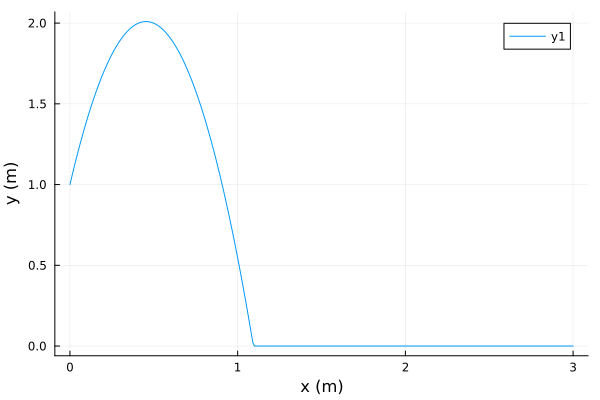

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8703


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("brick" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x68, 0x63, 0x61, 0x74, 0x2f, 0x62, 0x72, 0x69, 0x63, 0x6b], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8703))

In [43]:
include(joinpath(@__DIR__, "animate_brick.jl"))
let 
    
    dt = 0.01 
    T = 3.0 
    
    t_vec = 0:dt:T
    N = length(t_vec)
    
    qs = [zeros(2) for i = 1:N]
    vs = [zeros(2) for i = 1:N]
    
    qs[1] = [0, 1.0]
    vs[1] = [1, 4.5]
    
    # TODO: simulate the brick by forming and solving a qp 
    # at each timestep. Your QP should solve for vs[k+1], and
    # you should use this to update qs[k+1]
    for i=1:N-1
        qp = brick_simulation_qp(qs[i], vs[i]; Δt=dt)
        vs[i+1] .= solve_qp(qp)[1]
        qs[i+1] .= qs[i] + dt*vs[i+1]
    end

    
    xs = [q[1] for q in qs]
    ys = [q[2] for q in qs]
    
    @show @test abs(maximum(ys)-2)<1e-1
    @show @test minimum(ys) > -1e-2
    @show @test abs(xs[end] - 3) < 1e-2
    
    xdot = diff(xs)/dt
    @show @test maximum(xdot) < 1.0001
    @show @test minimum(xdot) > 0.9999
    @show @test ys[110] > 1e-2
    @show @test abs(ys[111]) < 1e-2
    @show @test abs(ys[112]) < 1e-2
    
    display(plot(xs, ys, ylabel = "y (m)", xlabel = "x (m)"))
    
    animate_brick(qs)
    
    
    
end